In [14]:
import numpy as np
from scipy.optimize import fsolve

def hocelms_dde_solver(f, tau, phi, t0, T, h=0.1, max_iter=10, tol=1e-6):
    """
    Giải phương trình vi phân có trễ bằng HOCELMs bậc 4
    y'(t) = f(t, y(t), y(t - τ(t, y))) với y(t) = φ(t) khi t ≤ t0
    
    Tham số:
    f : function(t, y, z) -> float
        Hàm vế phải (z = y(t - τ))
    tau : function(t, y) -> float
        Hàm trễ
    phi : function(t) -> float
        Điều kiện lịch sử
    t0 : float
        Thời điểm bắt đầu
    T : float
        Thời điểm kết thúc
    h : float
        Kích thước bước
    max_iter : int
        Số lần lặp tối đa cho mỗi bước
    tol : float
        Ngưỡng hội tụ
        
    Trả về:
    t : np.array
        Mảng thời điểm
    y : np.array
        Nghiệm tại các thời điểm
    Y_continuous : function
        Hàm liên tục trả về giá trị xấp xỉ tại bất kỳ t nào
    """
    # Khởi tạo lưới thời gian
    t_points = np.arange(t0, T + h, h)
    n = len(t_points)
    y_values = np.zeros(n)
    
    # Lịch sử dưới dạng các đoạn đa thức
    history = []

    # Áp đặt điều kiện ban đầu
    for i in range(n):
        if t_points[i] <= t0:
            y_values[i] = phi(t_points[i])
    
    # Hệ số HOCELMs bậc 4
    alpha = [0.5, 0.5]   # Hệ số phương pháp hình thang
    beta = [-1/12, 1/12] # Hiệu chỉnh bậc cao

    # Hàm nội suy giá trị trễ từ lịch sử
    def interpolate_history(s):
        for start, end, coeffs in reversed(history):
            if start <= s <= end:
                return np.polyval(coeffs, s - start)
        return phi(s)

    # Vòng lặp chính qua các bước thời gian
    for i in range(1, n):
        t_current = t_points[i]
        t_prev = t_points[i-1]
        
        # Tính giá trị trễ tại thời điểm hiện tại
        def compute_delayed_values(y_current):
            tau_val = tau(t_current, y_current)
            t_delayed = t_current - tau_val
            return interpolate_history(t_delayed)
        
        # Công thức dự đoán (Euler)
        z_delayed = compute_delayed_values(y_values[i-1])
        y_pred = y_values[i-1] + h * f(t_prev, y_values[i-1], z_delayed)
        
        # Lặp hiệu chỉnh
        for _ in range(max_iter):
            z_delayed = compute_delayed_values(y_pred)
            f_current = f(t_current, y_pred, z_delayed)
            
            # Tính đạo hàm bằng sai phân
            if i > 1:
                z_delayed_prev = compute_delayed_values(y_values[i-2])
                f_prev = f(t_prev, y_values[i-1], z_delayed_prev)
                f_prime = (f_current - f_prev) / h
            else:
                # Xử lý bước đầu tiên
                f_prime = 0
            
            # Công thức HOCELMs bậc 4
            y_corrected = y_values[i-1] + h * (
                alpha[0] * f_prev + 
                alpha[1] * f_current
            ) + h**2 * (
                beta[0] * f_prime + 
                beta[1] * f_current
            )
            
            # Kiểm tra hội tụ
            if abs(y_corrected - y_pred) < tol:
                y_pred = y_corrected
                break
                
            y_pred = y_corrected
        
        y_values[i] = y_pred
        
        # Xây dựng hàm liên tục cho đoạn [t_{i-1}, t_i]
        # Sử dụng đa thức Hermite bậc 3 (4 điều kiện)
        z_delayed_final = compute_delayed_values(y_values[i])
        f_i = f(t_current, y_values[i], z_delayed_final)
        
        # Điều kiện tại t_{i-1} và t_i
        # Y(t_{i-1}) = y_{i-1}, Y'(t_{i-1}) = f_{i-1}
        # Y(t_i) = y_i, Y'(t_i) = f_i
        A = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [1, h, h**2, h**3],
            [0, 1, 2*h, 3*h**2]
        ])
        
        b = np.array([
            y_values[i-1],
            f(t_prev, y_values[i-1], compute_delayed_values(y_values[i-1])),
            y_values[i],
            f_i
        ])
        
        # Giải hệ phương trình
        try:
            coeffs = np.linalg.solve(A, b).flatten()
            history.append((t_prev, t_current, coeffs))
        except np.linalg.LinAlgError:
            # Dự phòng nếu ma trận suy biến
            coeffs = [y_values[i-1], 0, 0, 0]
            history.append((t_prev, t_current, coeffs))

    # Hàm xấp xỉ liên tục toàn cục
    def Y_continuous(t):
        for start, end, coeffs in history:
            if start <= t <= end:
                return np.polyval(coeffs, t - start)
        # Trước t0 hoặc sau T
        if t <= t0:
            return phi(t)
        # Ngoại suy tuyến tính nếu cần
        return y_values[-1] + (t - t_points[-1]) * f(t_points[-1], y_values[-1], interpolate_history(t_points[-1] - tau(t_points[-1], y_values[-1])))
    
    return t_points, y_values, Y_continuous

# Ví dụ sử dụng
if __name__ == "__main__":
    # Hàm test: y'(t) = -2y(t) - y(t-1)
    def f(t, y, z):
        return -2 * y - z
    
    def tau(t, y):
        return 1.0  # Trễ cố định
    
    def phi(t):
        return 1.0  # Điều kiện ban đầu
    
    # Thông số giải
    t0 = 0.0
    T = 5.0
    h = 0.1
    
    # Giải phương trình
    t, y, Y = hocelms_dde_solver(f, tau, phi, t0, T, h)
    
    # Kết quả
    print("Kết quả tại các điểm lưới:")
    print("t =", t[:5], "...")
    print("y =", np.round(y[:5], 4), "...")
    
    # Kiểm tra tại điểm bất kỳ
    t_test = 2.75
    print(f"\nKiểm tra tại t = {t_test}:")
    print("Giá trị xấp xỉ liên tục: y(2.75) ≈", round(Y(t_test), 4))
    
    # So sánh với giá trị trên lưới gần nhất
    idx = np.searchsorted(t, t_test)
    t_near = t[idx]
    print(f"Giá trị trên lưới gần nhất (t={t_near}): y={y[idx]:.4f}")

UnboundLocalError: local variable 'f_prev' referenced before assignment

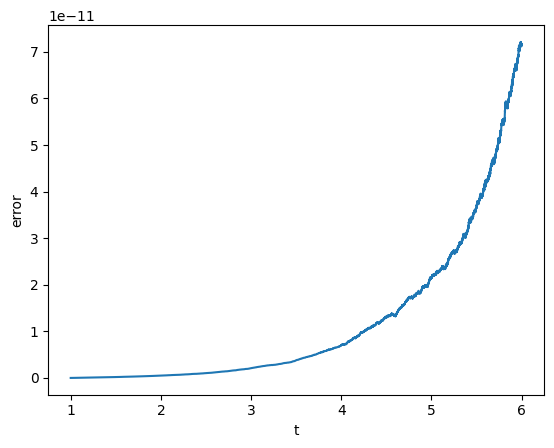

7.213429853436537e-11


In [3]:
#tính sai số
y_exact = [np.exp(t) for t in t_values]
error = np.abs(np.array(y_values) - np.array(y_exact))
#vẽ đồ thị sai số
plt.plot(t_values, error)
plt.xlabel('t')
plt.ylabel('error')
# plt.yscale('log')
plt.show()
print(max(error))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Hệ số CERK4 (6 stages) ----
c = np.array([0,
              1/6,
              11/37,
              11/17,
              13/15,
              1], dtype=float)

a = np.zeros((6,6))
a[1,0] = 1/6
a[2,0], a[2,1] =  44/1369,   363/1369
a[3,0], a[3,1], a[3,2] =  3388/4913,  -8349/4913,  8140/4913
a[4,0], a[4,1], a[4,2], a[4,3] = -36764/408375, 767/1125, -32708/136125, 210392/408375
a[5,0], a[5,1], a[5,2], a[5,3], a[5,4] = 1697/18876, 0, 50653/116160, 299693/1626240, 3375/11648

# continuous‐extension weights b_i(θ):
def b1(θ): return (-866577/824252)*θ**4 + (1806901/618189)*θ**3 - (104217/37466)*θ**2 + θ
def b2(θ): return 0.0
def b3(θ): return (12308679/5072320)*θ**4 - (2178079/380424)*θ**3 + (861101/230560)*θ**2
def b4(θ): return -(7816583/10144640)*θ**4 + (6244423/5325936)*θ**3 - (638869/293440)*θ**2
def b5(θ): return -(624375/217984)*θ**4 + (982125/190736)*θ**3 - (1522125/762944)*θ**2
def b6(θ): return (296/131)*θ**4 - (461/131)*θ**3 + (165/131)*θ**2

b_funcs = [b1, b2, b3, b4, b5, b6]
b_disc  = np.array([bf(1.0) for bf in b_funcs], dtype=float)


# ---- 2) Một bước CERK ----
def cerk_step(f, history, t, y, h, tau):
    K = []
    for i in range(6):
        ti = t + c[i]*h
        yi = y.copy()
        if i > 0:
            incr = np.zeros_like(y)
            for j in range(i):
                incr += a[i,j] * K[j]
            yi = yi + h*incr

        y_delay = history(ti - tau)
        Ki = f(ti, yi, y_delay)        # Ki cũng là vector độ dài d
        K.append(Ki)

    y_next = y + h * sum(b_disc[i]*K[i] for i in range(6))
    return y_next, K


# ---- 3) Solver chính với adaptive step (step‐doubling) ----
def solve_dde_cerk4(f, phi, t0, t_end, tau,
                    h0=0.1, tol=1e-6, max_steps=100000):
    # segments lưu (t_n, y_n, h_n, K_n) để nội suy y(t-τ)
    segments = []

    def history(s):
        if s <= t0:
            return np.atleast_1d(phi(s))
        # tìm segment chứa s
        for t_n, y_n, h_n, K_n in segments:
            if t_n <= s <= t_n + h_n:
                θ = (s - t_n)/h_n
                val = y_n + h_n * sum(b_funcs[i](θ)*K_n[i] for i in range(6))
                return val
        # nếu vượt segment cuối
        return segments[-1][1]

    t = t0
    y = np.atleast_1d(phi(t0))
    ts, ys = [t], [y.copy()]
    h = min(h0, tau)
    step = 0

    while t < t_end and step < max_steps:
        if t + h > t_end: h = t_end - t

        # full step
        y_full, K_full = cerk_step(f, history, t, y, h, tau)
        # two half-steps
        y_h1, K_h1 = cerk_step(f, history, t, y, h/2, tau)

        # tạm thêm segment nửa đầu để nội suy trong nửa sau
        seg_half = (t, y, h/2, K_h1)
        def hist2(s):
            if s <= t0: return np.atleast_1d(phi(s))
            if t <= s <= t + h/2:
                θ = (s-t)/(h/2)
                return y + (h/2)*sum(b_funcs[i](θ)*K_h1[i] for i in range(6))
            return history(s)

        y_h2, _ = cerk_step(f, hist2, t + h/2, y_h1, h/2, tau)
        # ước lượng error
        err = np.max(np.abs(y_h2 - y_full))
        if err < tol:
            # accept
            segments.append((t, y.copy(), h, K_full))
            t += h; y = y_h2.copy()
            ts.append(t); ys.append(y.copy())
            fac = np.clip((tol/err)**(1/5), 0.2, 5.0)
            h = min(h*fac, tau, t_end - t)
        else:
            fac = np.clip((tol/err)**(1/5), 0.1, 0.8)
            h *= fac

        step += 1

    return np.array(ts), np.vstack(ys)


# ---- 4) Ví dụ hệ 2 chiều ----
if __name__ == "__main__":

    α, β, τ = 2.0, 1.5, 0.1

    def phi(t):
        return np.array([1.0])

    def f(t, y, y_delay):
        y = np.atleast_1d(y)
        y_delay = np.atleast_1d(y_delay)
        return -1000*y+999*y_delay

    ts, ys = solve_dde_cerk4(f, phi, t0=0.0, t_end=0.5,
                             tau=τ, h0=0.1, tol=1e-5)

    plt.plot(ts, ys)
    # plt.plot(ts, ys[:,1], label="y2(t)")
    plt.legend(); plt.xlabel("t"); plt.show()


KeyboardInterrupt: 

In [20]:
import itertools
from math import prod

# Define the rooted tree structure
class Tree:
    def __init__(self, children):
        self.children = tuple(children)
    
    def order(self):
        # number of nodes in subtree
        return 1 + sum(child.order() for child in self.children)
    
    def canonical(self):
        # unique repr by sorted children reprs
        child_reprs = sorted(child.canonical() for child in self.children)
        return "(" + "".join(child_reprs) + ")"
    
    def __repr__(self):
        return self.canonical()

# Generate integer partitions for tree construction
def integer_partitions(n, max_val=None):
    if n == 0:
        return [[]]
    if max_val is None or max_val > n:
        max_val = n
    parts = []
    for k in range(max_val, 0, -1):
        for rest in integer_partitions(n - k, k):
            parts.append([k] + rest)
    return parts

# Generate all non-isomorphic rooted trees up to order p
def generate_trees(p):
    T = {1: [Tree([])]}
    for n in range(2, p+1):
        unique = {}
        for part in integer_partitions(n-1):
            for combo in itertools.product(*(T[k] for k in part)):
                t = Tree(combo)
                unique[t.canonical()] = t
        T[n] = list(unique.values())
    return T

# Classical continuous-extension gamma: product of sizes of all subtrees
def gamma(tree):
    if not tree.children:
        return 1
    return tree.order() * prod(gamma(child) for child in tree.children)

# Generate phi_i(t) for continuous RK:
varnames = ['j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r']

def phi_cont(tree, parent='i', idx=0):
    """Return (expr_str, next_idx, indices_list) for phi_i(t)."""
    if not tree.children:
        # leaf: c_i
        return f"c_{parent}", idx, []
    expr_parts = []
    indices = []
    for child in tree.children:
        if not child.children:
            # leaf child: factor c_parent
            expr_parts.append(f"c_{parent}")
        else:
            # non-leaf: add a sum over new index var
            var = varnames[idx]
            idx += 1
            subexpr, idx, subinds = phi_cont(child, parent=var, idx=idx)
            expr_parts.append(f"Σ_{{{var}}} a_{{{parent}{var}}}*({subexpr})")
            indices.append(var)
            indices.extend(subinds)
    return " * ".join(expr_parts), idx, indices

# Print continuous extension conditions up to order p
def print_dense_conditions(p):
    trees = generate_trees(p)
    for k in range(1, p+1):
        print(f"--- Order {k} ---")
        for t in trees[k]:
            expr, _, inds = phi_cont(t)
            gamma_t = gamma(t)
            # build sum indices string
            all_inds = ['i'] + inds
            sum_sub = ",".join(all_inds)
            print(f"Σ_{{{sum_sub}}} b_i(θ) * {expr} = 1/{gamma_t} θ^{k}")
        print()

# Example usage
if __name__ == "__main__":
    print_dense_conditions(6)


--- Order 1 ---
Σ_{i} b_i(θ) * c_i = 1/1 θ^1

--- Order 2 ---
Σ_{i} b_i(θ) * c_i = 1/2 θ^2

--- Order 3 ---
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) = 1/6 θ^3
Σ_{i} b_i(θ) * c_i * c_i = 1/3 θ^3

--- Order 4 ---
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k)) = 1/24 θ^4
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j) = 1/12 θ^4
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) * c_i = 1/8 θ^4
Σ_{i} b_i(θ) * c_i * c_i * c_i = 1/4 θ^4

--- Order 5 ---
Σ_{i,j,k,l} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(Σ_{l} a_{kl}*(c_l))) = 1/120 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k * c_k)) = 1/60 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k) * c_j) = 1/40 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j * c_j) = 1/20 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(Σ_{k} a_{jk}*(c_k)) * c_i = 1/30 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j * c_j) * c_i = 1/15 θ^5
Σ_{i,j,k} b_i(θ) * Σ_{j} a_{ij}*(c_j) * Σ_{k} a_{ik}*(c_k) = 1/20 θ^5
Σ_{i,j} b_i(θ) * Σ_{j} a_{ij}*(c_j) * c_i * c_i = 1/10 θ^5
Σ_{i} b_i(θ) * c_i * c_i * c

/var/folders/5x/j_16mfls3qqgbh5fp43y8l140000gp/T/ipykernel_86519/940624477.py:79: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.chi[i] += jump_magnitudes[jp] * (dt ** self.p) / np.math.factorial(self.p)
/var/folders/5x/j_16mfls3qqgbh5fp43y8l140000gp/T/ipykernel_86519/940624477.py:80: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.dchi[i] += jump_magnitudes[jp] * (dt ** (self.p-1)) / np.math.factorial(self.p-1)
/var/folders/5x/j_16mfls3qqgbh5fp43y8l140000gp/T/ipykernel_86519/940624477.py:114: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  chi_delayed += self.chi[np.where(self.t == jp)[0][0]] * (dt ** self.p) / np.math.factorial(self.p)


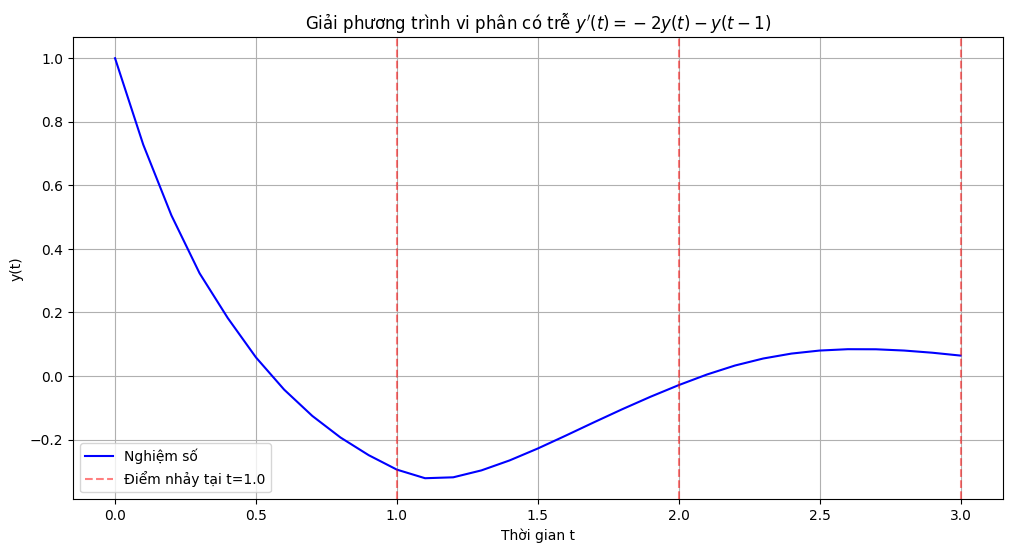

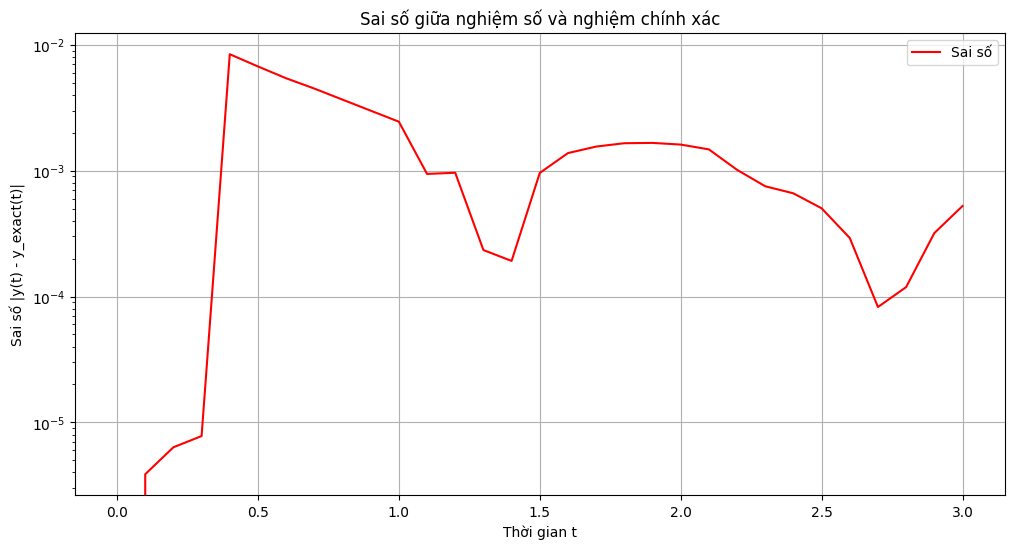

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

class RigorousFDESolver:
    def __init__(self, f, phi, tau, t0, tf, h, jump_points=None, order=4):
        """
        Bộ giải FDE/DDE bậc cao với hiệu chỉnh bước nhảy chính xác
        
        :param f: Hàm f(t, x_t) -> dx/dt (x_t là hàm lịch sử)
        :param phi: Hàm lịch sử φ(t) cho t ≤ t0
        :param tau: Hàm trễ τ(t, x(t)) -> giá trị trễ dương
        :param t0: Thời điểm bắt đầu
        :param tf: Thời điểm kết thúc
        :param h: Bước thời gian
        :param jump_points: Danh sách các điểm bước nhảy đã biết
        :param order: Bậc của phương pháp (mặc định 4)
        """
        # ================ THIẾT LẬP THAM SỐ ================
        self.f = f
        self.phi = phi
        self.tau = tau
        self.t0 = t0
        self.tf = tf
        self.h = h
        self.p = order  # Bậc phương pháp
        
        # Xử lý điểm bước nhảy (chỉ lấy điểm trong khoảng giải)
        self.jump_points = sorted([jp for jp in (jump_points or []) if t0 < jp <= tf])
        
        # Tạo lưới thời gian với các điểm bước nhảy
        self.t = np.unique(np.sort(np.concatenate([
            np.arange(t0, tf + h, h),
            np.array(self.jump_points)
        ])))
        self.n = len(self.t)
        
        # ================ KHỞI TẠO BIẾN TRẠNG THÁI ================
        self.y = np.zeros(self.n)      # Nghiệm toàn phần x(t)
        self.w = np.zeros(self.n)      # Phần trơn x_{(p)}(t) = x(t) - χ(t)
        self.dw = np.zeros(self.n)     # Đạo hàm phần trơn
        self.f_vals = np.zeros(self.n) # Giá trị F(t, x_t)
        
        # Khởi tạo hàm hiệu chỉnh bước nhảy
        self.chi = np.zeros(self.n)
        self.dchi = np.zeros(self.n)
        
        # ================ ĐIỀU KIỆN BAN ĐẦU ================
        for i, t_val in enumerate(self.t):
            if t_val <= t0:
                self.y[i] = phi(t_val)
        
        # Chỉ số bắt đầu tích phân
        self.idx0 = np.where(self.t == t0)[0][0] if t0 in self.t else 0
        
        # ================ TÍNH TOÁN HÀM HIỆU CHỈNH ================
        self.compute_jump_correction()
        
        # Khởi tạo phần trơn tại điều kiện ban đầu
        for i in range(self.n):
            if self.t[i] <= t0:
                self.w[i] = self.y[i] - self.chi[i]
    
    def compute_jump_correction(self):
        """Tính toán hàm hiệu chỉnh bước nhảy χ(t) theo lý thuyết"""
        # Reset hàm hiệu chỉnh
        self.chi = np.zeros(self.n)
        self.dchi = np.zeros(self.n)
        
        # Tính toán bước nhảy tại mỗi điểm (cần dữ liệu thực tế)
        # Ở đây sử dụng giá trị giả định cho mục đích minh họa
        jump_magnitudes = {jp: 0.1 * np.exp(-jp) for jp in self.jump_points}
        
        # Xây dựng χ(t) = Σ c_ν * (t - s_ν)^p * H(t - s_ν)
        for jp in self.jump_points:
            idx = np.searchsorted(self.t, jp)
            for i in range(idx, self.n):
                dt = self.t[i] - jp
                self.chi[i] += jump_magnitudes[jp] * (dt ** self.p) / np.math.factorial(self.p)
                self.dchi[i] += jump_magnitudes[jp] * (dt ** (self.p-1)) / np.math.factorial(self.p-1)
    
    def interpolate_history(self, t_eval, current_idx):
        """Nội suy lịch sử bằng spline bậc 3 với độ chính xác cao"""
        if t_eval <= self.t0:
            return self.phi(t_eval)
        
        # Chỉ xem xét các điểm đã được tính toán
        valid_idx = min(current_idx + 1, self.n)
        t_known = self.t[:valid_idx]
        w_known = self.w[:valid_idx]
        
        # Sử dụng CubicSpline để nội suy phần trơn
        if len(t_known) < 2:
            return w_known[0] if len(w_known) > 0 else 0.0
        
        # Tạo spline với điều kiện biên tự nhiên
        spline = CubicSpline(t_known, w_known, bc_type='natural')
        return spline(t_eval)
    
    def get_delayed_value(self, t, current_idx):
        """Lấy giá trị trễ với hiệu chỉnh bước nhảy chính xác"""
        # Tính thời điểm trễ
        tau_val = self.tau(t, self.y[current_idx])
        delayed_t = t - tau_val
        
        # Nội suy phần trơn w(t - τ)
        w_delayed = self.interpolate_history(delayed_t, current_idx)
        
        # Tính χ tại thời điểm trễ
        chi_delayed = 0.0
        for jp in self.jump_points:
            if delayed_t > jp:
                dt = delayed_t - jp
                chi_delayed += self.chi[np.where(self.t == jp)[0][0]] * (dt ** self.p) / np.math.factorial(self.p)
        
        return w_delayed + chi_delayed
    
    def runge_kutta_step(self, i):
        """Bước tích phân RK4 cho phần trơn w(t)"""
        t_i = self.t[i]
        w_i = self.w[i]
        h = self.h
        
        # Tính giá trị trễ
        delayed_val1 = self.get_delayed_value(t_i, i)
        k1 = self.f(t_i, self.y[i], delayed_val1) - self.dchi[i]
        
        # Bước 2
        t_temp = t_i + 0.5*h
        w_temp = w_i + 0.5*h*k1
        y_temp = w_temp + self.chi[i] + 0.5*h*self.dchi[i]
        delayed_val2 = self.get_delayed_value(t_temp, i)
        k2 = self.f(t_temp, y_temp, delayed_val2) - self.dchi[i]
        
        # Bước 3
        w_temp = w_i + 0.5*h*k2
        y_temp = w_temp + self.chi[i] + 0.5*h*self.dchi[i]
        delayed_val3 = self.get_delayed_value(t_temp, i)
        k3 = self.f(t_temp, y_temp, delayed_val3) - self.dchi[i]
        
        # Bước 4
        t_next = t_i + h
        w_temp = w_i + h*k3
        y_temp = w_temp + self.chi[i] + h*self.dchi[i]
        delayed_val4 = self.get_delayed_value(t_next, i)
        k4 = self.f(t_next, y_temp, delayed_val4) - self.dchi[i+1]
        
        # Cập nhật
        self.w[i+1] = w_i + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        self.y[i+1] = self.w[i+1] + self.chi[i+1]
        
        # Tính giá trị f mới
        delayed_val_next = self.get_delayed_value(t_next, i+1)
        self.f_vals[i+1] = self.f(t_next, self.y[i+1], delayed_val_next)
        self.dw[i+1] = self.f_vals[i+1] - self.dchi[i+1]
    
    def adams_moulton_step(self, i):
        """Bước Adams-Moulton bậc 4 cho phần trơn w(t)"""
        h = self.h
        
        # Dự đoán (Adams-Bashforth bậc 4)
        w_pred = self.w[i] + h/24 * (
            55*self.dw[i] - 59*self.dw[i-1] + 37*self.dw[i-2] - 9*self.dw[i-3]
        )
        y_pred = w_pred + self.chi[i+1]
        
        # Tính giá trị trễ với dự đoán
        delayed_val_pred = self.get_delayed_value(self.t[i+1], i)
        f_pred = self.f(self.t[i+1], y_pred, delayed_val_pred)
        dw_pred = f_pred - self.dchi[i+1]
        
        # Sửa (Adams-Moulton bậc 4)
        w_corr = self.w[i] + h/24 * (
            9*dw_pred + 19*self.dw[i] - 5*self.dw[i-1] + self.dw[i-2]
        )
        y_corr = w_corr + self.chi[i+1]
        
        # Tính lại giá trị trễ với nghiệm đã sửa
        delayed_val_corr = self.get_delayed_value(self.t[i+1], i+1)
        f_corr = self.f(self.t[i+1], y_corr, delayed_val_corr)
        dw_corr = f_corr - self.dchi[i+1]
        
        # Cập nhật (sử dụng giá trị sửa)
        self.w[i+1] = w_corr
        self.y[i+1] = y_corr
        self.dw[i+1] = dw_corr
        self.f_vals[i+1] = f_corr
    
    def solve(self):
        """Giải phương trình với độ chính xác cao"""
        # ================ KHỞI ĐỘNG BẰNG RK4 ================
        for i in range(self.idx0, min(self.idx0 + 4, self.n - 1)):
            self.runge_kutta_step(i)
        
        # ================ TÍCH PHÂN ĐA BƯỚC ================
        for i in range(self.idx0 + 3, self.n - 1):
            self.adams_moulton_step(i)
        
        return self.t, self.y

# =============================================================
# PHẦN TEST: GIẢI PHƯƠNG TRÌNH y'(t) = -2*y(t) - y(t-1)
# =============================================================
def test_equation(t, y, y_delayed):
    return -2 * y - y_delayed

def constant_tau(t, y):
    return 1.0

def phi_history(t):
    return 1.0

# Tham số giải
t0 = 0.0
tf = 3.0
h = 0.1  # Giảm bước thời gian để tăng độ chính xác
jump_points = [1.0, 2.0, 3.0]  # Các điểm bước nhảy

# Tạo solver và giải
solver = RigorousFDESolver(
    f=test_equation,
    phi=phi_history,
    tau=constant_tau,
    t0=t0,
    tf=tf,
    h=h,
    jump_points=jump_points,
    order=4
)

t, y = solver.solve()

# Lưu kết quả để so sánh với nghiệm chính xác
np.savetxt('computed_solution.txt', np.column_stack((t, y)))

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(t, y, 'b-', linewidth=1.5, label='Nghiệm số')
for jp in jump_points:
    plt.axvline(x=jp, color='r', linestyle='--', alpha=0.5, label=f'Điểm nhảy tại t={jp}' if jp == jump_points[0] else "")
plt.title('Giải phương trình vi phân có trễ $y\'(t) = -2y(t) - y(t-1)$')
plt.xlabel('Thời gian t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()
# sai số
y_exact = np.loadtxt('y_exact01.txt')
error = np.abs(y - y_exact)
plt.figure(figsize=(12, 6))
plt.plot(t, error, 'r-', linewidth=1.5, label='Sai số')
plt.title('Sai số giữa nghiệm số và nghiệm chính xác')
plt.xlabel('Thời gian t')
plt.ylabel('Sai số |y(t) - y_exact(t)|')
plt.yscale('log')  # Hiển thị sai số theo thang logarit
plt.grid(True)
plt.legend()
plt.show()

In [41]:
import numpy as np

def hermite_interpolate(t0, y0, f0, t1, y1, f1, t):
    """
    Nội suy Hermite bậc ba giữa (t0,y0,f0) và (t1,y1,f1).
    """
    h = t1 - t0
    s = (t - t0) / h
    return ((2*s**3 - 3*s**2 + 1)*y0 +
            (s**3 - 2*s**2 + s)*h*f0 +
            (-2*s**3 + 3*s**2)*y1 +
            (s**3 - s**2)*h*f1)

def dde_epmm_2_4(f, phi, t0, t_end, tau, h):
    """
    Giải DDE y' = f(t, y, y_delayed) trên [t0, t_end] với độ trễ tau,
    bước cố định h, phương pháp EPMM (2,4).
    
    f: hàm trả về f(t, y, y_delay)
    phi: hàm lịch sử cho y(t) với t <= t0
    """
    # Khởi tạo
    y0 = phi(t0)
    f0 = f(t0, y0, phi(t0 - tau))
    y1 = y0 + h * f0                             # Euler khởi đầu :contentReference[oaicite:8]{index=8}
    f1 = f(t0 + h, y1, phi(t0 + h - tau))
    
    t_vals = [t0, t0 + h]
    y_vals = [y0, y1]
    f_vals = [f0, f1]
    
    result_t = np.arange(t0, t_end + h/2, h)
    result_y = [y0, y1]
    
    # Vòng lặp time-stepping
    for n in range(1, len(result_t)-1):
        t_n = t_vals[-1]
        # Predictor (AB2)
        y_pred = y_vals[-1] + h*(1.5*f_vals[-1] - 0.5*f_vals[-2])
        
        # Xác định y_delayed cho t = t_n + h
        t_pred = t_n + h
        t_delay = t_pred - tau
        if t_delay < t0:
            y_delay = phi(t_delay)                # dùng hàm lịch sử :contentReference[oaicite:9]{index=9}
        else:
            # tìm vị trí trong lịch sử
            for i in range(len(t_vals)-1):
                if t_vals[i] <= t_delay <= t_vals[i+1]:
                    y_delay = hermite_interpolate(
                        t_vals[i], y_vals[i], f_vals[i],
                        t_vals[i+1], y_vals[i+1], f_vals[i+1],
                        t_delay)
                    break
        
        f_pred = f(t_pred, y_pred, y_delay)
        
        # Corrector (AM2)
        y_next = y_vals[-1] + (h/12)*(5*f_pred + 8*f_vals[-1] - f_vals[-2])
        
        # Cập nhật f tại bước mới
        # Lặp lại nội suy cho y_delay tại t = t_pred nếu cần (thường giống trên)
        if t_delay < t0:
            y_delay_next = phi(t_pred - tau)
        else:
            # nội suy lại giữa y_vals[-2], y_vals[-1]
            y_delay_next = hermite_interpolate(
                t_vals[-1], y_vals[-1], f_vals[-1],
                t_pred,        y_pred,    f_pred,
                t_pred - tau)
        
        f_next = f(t_pred, y_next, y_delay_next)
        
        # Giữ buffer hai điểm gần nhất
        t_vals.append(t_pred); t_vals.pop(0)
        y_vals.append(y_next); y_vals.pop(0)
        f_vals.append(f_next); f_vals.pop(0)
        
        result_y.append(y_next)
    
    return np.array(result_t), np.array(result_y)


Kết quả tại các điểm lưới:
t = [0.  0.1 0.2 0.3 0.4] ...
y = [1.     0.7    0.4825 0.3042 0.1582] ...


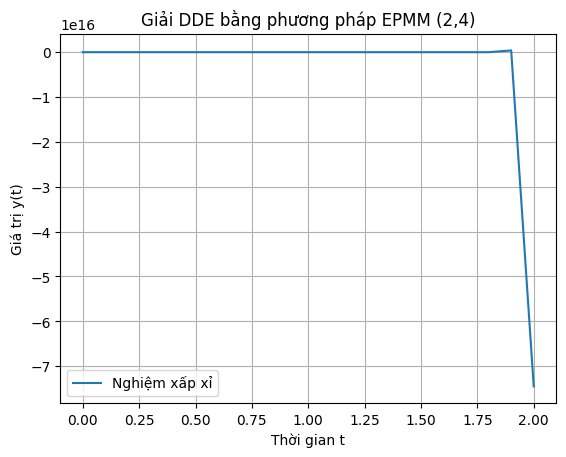

In [46]:
def f(t, y, y_delay):
    """
    Hàm mẫu f(t, y, y_delay) = -2y - y_delay.
    """
    return -2 * y - y_delay
def phi(t):
    """
    Hàm lịch sử mẫu φ(t) = 1.0 cho t <= t0.
    """
    return 1.0
def tau(t, y):
    """
    Hàm trễ mẫu τ(t, y) = 1.0 (trễ cố định).
    """
    return 1.0
def main():
    # Thông số giải
    t0 = 0.0
    t_end = 2.0
    h = 0.1
    
    # Giải phương trình DDE
    t_vals, y_vals = dde_epmm_2_4(f, phi, t0, t_end, 1.0, h)
    
    # Hiển thị kết quả
    print("Kết quả tại các điểm lưới:")
    print("t =", t_vals[:5], "...")
    print("y =", np.round(y_vals[:5], 4), "...")
    
    # Vẽ đồ thị kết quả
    import matplotlib.pyplot as plt
    plt.plot(t_vals, y_vals, label='Nghiệm xấp xỉ')
    plt.xlabel('Thời gian t')
    plt.ylabel('Giá trị y(t)')
    plt.title('Giải DDE bằng phương pháp EPMM (2,4)')
    plt.legend()
    plt.grid()
    plt.show()
if __name__ == "__main__":
    main()
